In [1]:
# Sitting up the environnement
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold, learning_curve, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler, LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

Loading data

In [2]:
site_traffic_df = pd.read_csv("https://s3.amazonaws.com/talent-assets.datacamp.com/recipe_site_traffic_2212.csv", )
site_traffic_df

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN
...,...,...,...,...,...,...,...,...
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,NaN
943,944,NaN,NaN,NaN,NaN,Potato,2,High
944,945,951.74,29.42,3.57,13.87,Pork,2,High
945,946,266.61,35.77,0.97,8.07,Potato,6,High


Data info

In [3]:
site_traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


First things first, we can see that there is some data missing in calories, carbohydrate, sugar, protein and high_traffic columns. Second, category, servings high_traffic columns are pandas objects (categorical).
According to the product manager 'servings' must be numerical so let's start with converting it to numeric.

1. ## Data Preprocessing

#### Dealing with "servings" column

Converting servings to integers as required

In [4]:
site_traffic_df['servings'].unique()

array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

As we can see, there are some elements in the servings column that must be processed in the form of {integer+"as a snack"}.

In [5]:
site_traffic_df['servings'] = pd.to_numeric(site_traffic_df['servings'].str.split().str[0], errors='coerce')

Let's check if the column's data type has changed to numerical (integer)

In [6]:
site_traffic_df['servings'].dtype

dtype('int64')

Okay, moving on..

#### Dealing with "category" column

What categories do we have ?

In [7]:
category_list = list(site_traffic_df['category'].unique())
print(category_list, "\nN°categories =",len(category_list))

['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal', 'Chicken Breast', 'Lunch/Snacks', 'Chicken', 'Vegetable', 'Meat', 'Dessert'] 
N°categories = 11


Comparing with the list provided by the manager

In [8]:
managers_category_list = ['Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat', 'Chicken', 'Pork', 'Dessert', 'Breakfast','One Dish Meal']
for cat in category_list:
    if cat not in managers_category_list:
        print(cat)

Chicken Breast


We can classify 'Chicken Breast' with the 'Chicken' category

In [9]:
site_traffic_df['category'] = site_traffic_df['category'].str.replace('Chicken Breast','Chicken')

Let's check now if we have the same categories as the manager's

In [10]:
print(site_traffic_df['category'].unique())
print(site_traffic_df['category'].unique().shape)

['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken'
 'Lunch/Snacks' 'Vegetable' 'Meat' 'Dessert']
(10,)


Great ! Moving on..

#### Dealing with "high_trafic" column

We only have 'High' traffic or null values in this column

In [11]:
site_traffic_df['high_traffic'].unique()

array(['High', nan], dtype=object)

In [12]:
missing_high_traffic = site_traffic_df['high_traffic'].isnull().sum()
missing_high_traffic

373

In [13]:
ratio = missing_high_traffic/len(site_traffic_df['high_traffic'])
ratio*100

39.38753959873284

About 39% of the data is missing in the 'high_traffic' column. At this stage we cannot define null values as 'High' or 'Not High' simply because the recipes aren't shown on the site yet (or shown but no high traffic was observed and no data was delivered, let's just call it unknown). Having a set of recipes we will be predicting the ones that lead to high traffic.

In [14]:
site_traffic_df['high_traffic'] = site_traffic_df['high_traffic'].fillna('unknown')
site_traffic_df['high_traffic'].sample(10)

857       High
12        High
775       High
292       High
682    unknown
457       High
385       High
744       High
35     unknown
797       High
Name: high_traffic, dtype: object

#### Dealing with missing values

For the rows that have null values for 'calories', 'carbohydrate', 'sugar' and 'protein' at once, it is better to drop them simply because without them we cannot define a recipe (and setting them to 0 or mean of data is not relevant).

In [15]:
columns_of_interest = ['calories', 'carbohydrate', 'sugar', 'protein']
missing_values_df = site_traffic_df[site_traffic_df[columns_of_interest].isnull().all(axis=1)]
missing_values_df

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
23,24,NaN,NaN,NaN,NaN,Meat,2,unknown
48,49,NaN,NaN,NaN,NaN,Chicken,4,unknown
82,83,NaN,NaN,NaN,NaN,Meat,4,High
89,90,NaN,NaN,NaN,NaN,Pork,6,High
116,117,NaN,NaN,NaN,NaN,Chicken,6,High
121,122,NaN,NaN,NaN,NaN,Dessert,2,High
136,137,NaN,NaN,NaN,NaN,One Dish Meal,2,High
149,150,NaN,NaN,NaN,NaN,Potato,2,High
187,188,NaN,NaN,NaN,NaN,Pork,4,High


We count 52 observations where 'calories', 'carbohydrate', 'sugar' and 'protein' columns all have null values at once. 52+895=947 which is the length of our dataset. Now we can drop the corresponding rows and we're sure that we're dropping only rows where we have null values for the four items.

In [16]:
site_traffic_df_cleaned = site_traffic_df.copy()
site_traffic_df_cleaned = site_traffic_df_cleaned.dropna(subset=columns_of_interest, how='all')
site_traffic_df_cleaned

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,unknown
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,unknown
5,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High
...,...,...,...,...,...,...,...,...
941,942,186.21,83.94,1.98,22.40,Chicken,4,High
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,unknown
944,945,951.74,29.42,3.57,13.87,Pork,2,High
945,946,266.61,35.77,0.97,8.07,Potato,6,High


Now that we have a clean dataset, let's explore it !

In [17]:
# Quick check
site_traffic_df_cleaned['high_traffic'].value_counts('unknown')*100

High       59.776536
unknown    40.223464
Name: high_traffic, dtype: float64

40% of the data is still to predict (unknown), we must be careful about our class imbalance.

2. ## Data Exploration

#### Dataset Description

In [18]:
site_traffic_df_cleaned.describe()

,recipe,calories,carbohydrate,sugar,protein,servings
count,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000
mean,473.652514,435.939196,35.069676,9.046547,24.149296,3.458101
std,272.763283,453.020997,43.949032,14.679176,36.369739,1.735979
min,2.000000,0.140000,0.030000,0.010000,0.000000,1.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000,2.000000
50%,475.000000,288.550000,21.480000,4.550000,10.800000,4.000000
75%,708.500000,597.650000,44.965000,9.800000,30.200000,4.000000
max,947.000000,3633.160000,530.420000,148.750000,363.360000,6.000000


Interquartile Range (IQR)

In [19]:
iqr = site_traffic_df_cleaned['calories'].quantile(0.75) - site_traffic_df_cleaned['calories'].quantile(0.25)

# just checking if we have the same quantiles in the description table
print("First Quantile:", site_traffic_df_cleaned['calories'].quantile(0.25), "Third Quantile", site_traffic_df_cleaned['calories'].quantile(0.75))

# Interquantile Range
print("IQR =", iqr)

First Quantile: 110.43 Third Quantile 597.65
IQR = 487.21999999999997


While the columns for 'recipe' and 'servings' may offer limited insight, the remaining columns in the dataset provide more substantial information for analysis.
I can read the results but the table is more insightful.
Let me analyze the 'calories' for you :
- Skewness: The median (288.55) being less than the mean (435.94) suggests a positively skewed distribution. This skewness is further indicated by the fact that the IQR (487.22) is larger than the mean.
- Variability: The large difference between the IQR and the median indicates substantial variability in the middle 50% of the dataset.
- Outliers: The large difference between the mean and the median, as well as the large IQR, suggest the possible presence of outliers on the higher end of the distribution. These outliers are likely influencing the mean and contributing to the positively skewed distribution.
- Central Tendency: The fact that the median is substantially lower than the mean indicates that the distribution is heavily influenced by the higher values, pulling the mean upwards. In this case, the median may be a more representative measure of central tendency, especially in the presence of outliers.

#### Some visualizations

To validate the previous interpretations let's visualize data.

<AxesSubplot: ylabel='calories'>

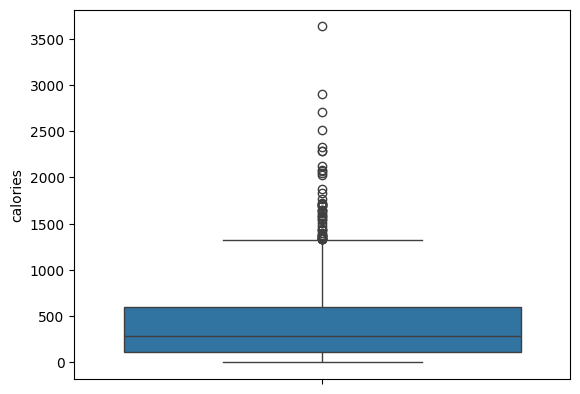

In [20]:
sns.boxplot(data=site_traffic_df_cleaned['calories'])

Most of 'calories' data is concentrated in the range [100,600]. Here we can observe the presence of outliers that can affect our analysis but we have a great solution for this which is data normalization, so let's not worry about this.

[]

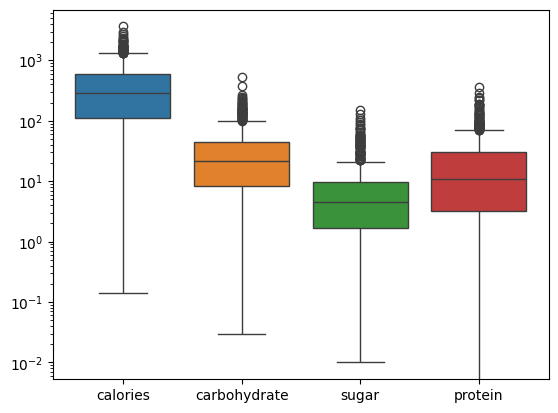

In [21]:
# Boxplot for all recipe elements
recipes_cols = site_traffic_df_cleaned.columns[1:-3]
sns.boxplot(data=site_traffic_df_cleaned[recipes_cols])
plt.semilogy()

We can see the presence of outliers also for the other items (recipe and servings are not representative).

Now let's verify the distribution skewness of 'calories'

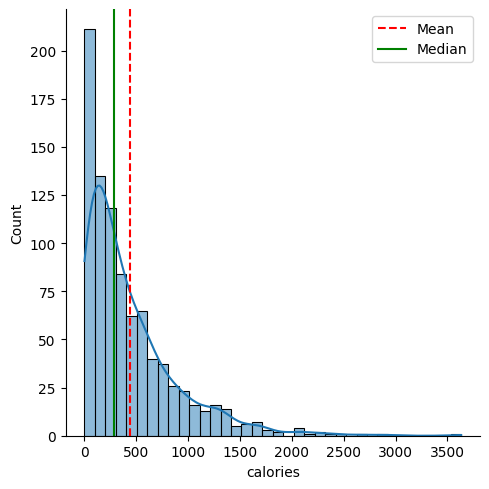

In [22]:
# plotting calories distribution
sns.displot(site_traffic_df_cleaned['calories'], kde='true')

# vertical line at the mean
plt.axvline(site_traffic_df_cleaned['calories'].mean(), color='r', linestyle='--', label='Mean')

# vertical line at the median
plt.axvline(site_traffic_df_cleaned['calories'].median(), color='g', linestyle='-', label='Median')

# legend
plt.legend()

# display
plt.show()

In [23]:
# skewness calculation
skewness = site_traffic_df_cleaned['calories'].skew()
print("Skewness:", skewness)

Skewness: 2.036150959685193


The value of skewness is greater than 1, this distribution is highly skewed to the right.

#### Relationship between two variables

Out of curiosity, let's plot the correlation matrix of recipes.

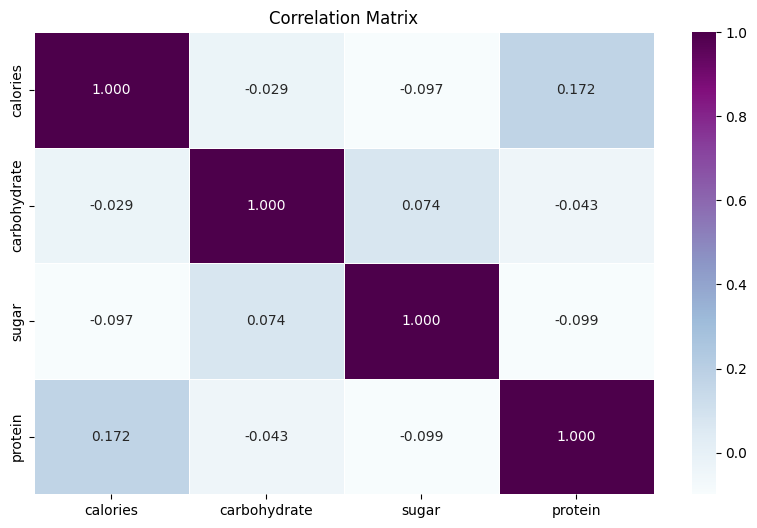

In [24]:
correlation_matrix = site_traffic_df_cleaned[recipes_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='BuPu', fmt=".3f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In this matrix we can see if we have positive or negative correlation between two variables (calories vs protein, sugar vs carbohydrate, sugar vs calories, etc.), it is important to note that this doesn't prove any relationship between these variables because one variable (calories for example) can depend on all the other variables and not only one.

Now a pairplot to see the distribution of each item and the distribution of each correlation between the varaibles.

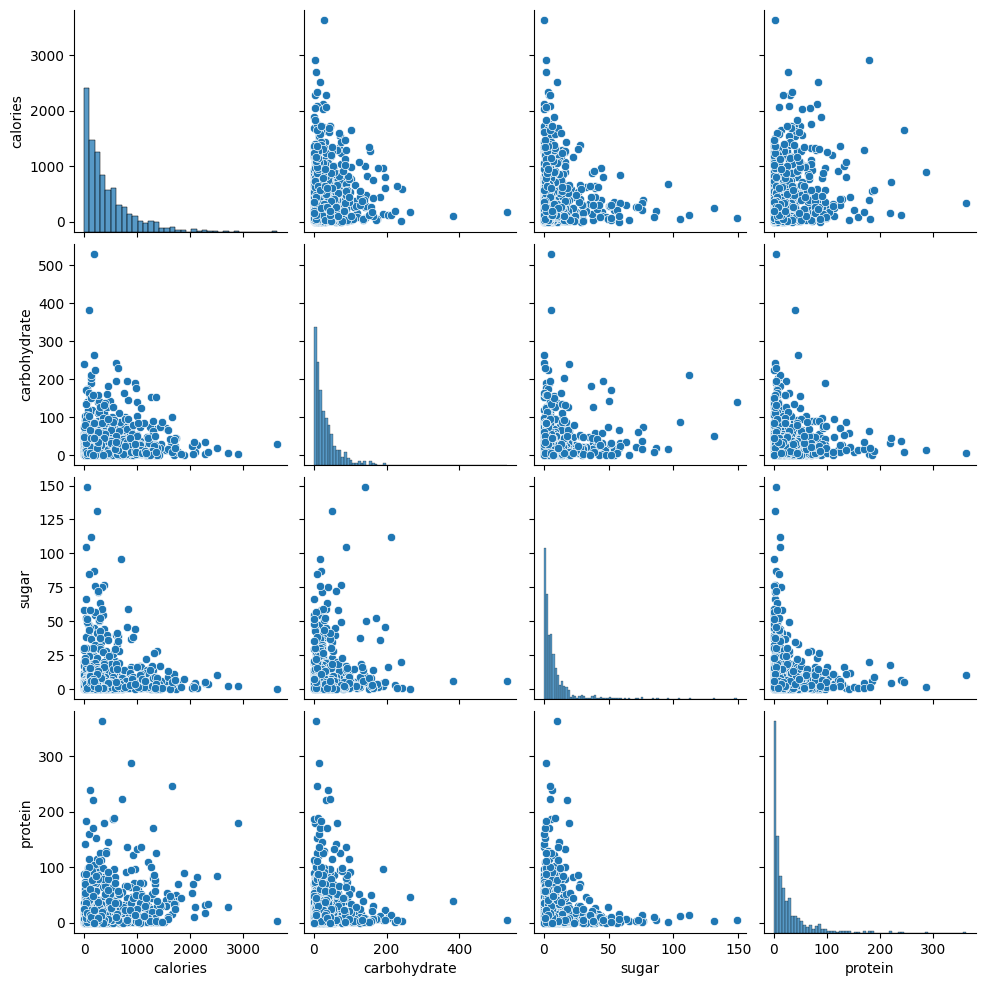

In [25]:
sns.pairplot(site_traffic_df_cleaned[recipes_cols])

#### Relationship between calories and category

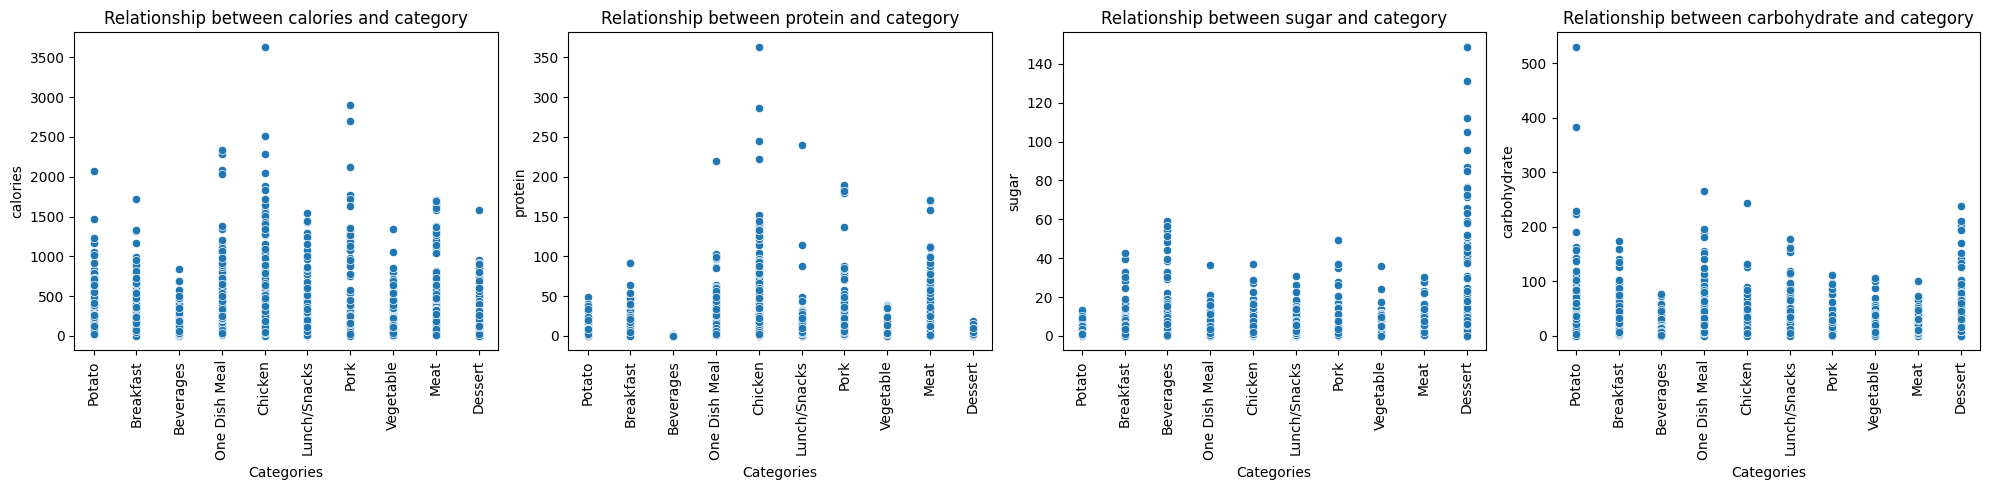

In [26]:
columns_to_plot = site_traffic_df_cleaned[['calories', 'protein', 'sugar', 'carbohydrate']]

# figure and subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# scatter plot in a separate subplot
for i, col in enumerate(columns_to_plot):
    sns.scatterplot(x=site_traffic_df_cleaned['category'], y=site_traffic_df_cleaned[col], ax=axes[i])
    axes[i].set_xlabel('Categories')
    axes[i].set_ylabel(str(col))
    axes[i].set_title(f'Relationship between {col} and category')
    axes[i].tick_params(axis='x', rotation=90)  # Rotate x-axis tick labels if needed

# layout adjusting and plot display
plt.tight_layout()
plt.show()

Here we can see that : 
- Chicken and Pork contain the highest calories
- Chicken, One Dish Meal and Lunch/Snack have the highest protein
- Dessert has the highest sugar
- Potato has the highest carbohydrate


# 3. Model Developement

Selecting a suitable model for this problem is relatively simple because the goal is now defined : predict which recipes lead to a High traffic. Traffic as a variable in this universe can take a binary state : 'High', 'Not High'. As a result, we can use logistic regression for to classify traffic. Other models like Decision Trees, Random Forests, Support Vector Machines (SVM), and Gradient Boosting Machines (GBM) also can be used but I personnaly prefer to apply cross-validation to select the most suitable model for any problem.

### 3.1. Model Selection : Corss-Validation

Before implementing any predictive model we must convert categorical data to numerical. I will be using a Label Encoder for this purpose.

In [27]:
label_encoder = LabelEncoder()

In [28]:
site_traffic_df_encoded = site_traffic_df_cleaned.copy()
site_traffic_df_encoded['category_encoded'] = label_encoder.fit_transform(site_traffic_df_encoded['category'])
site_traffic_df_encoded['traffic_encoded'] = label_encoder.fit_transform(site_traffic_df_encoded['high_traffic'])
site_traffic_df_encoded = site_traffic_df_encoded.drop(columns=['high_traffic', 'category'])
site_traffic_df_encoded

,recipe,calories,carbohydrate,sugar,protein,servings,category_encoded,traffic_encoded
1,2,35.48,38.56,0.66,0.92,4,8,0
2,3,914.28,42.68,3.09,2.88,1,1,1
3,4,97.03,30.56,38.63,0.02,4,0,0
4,5,27.05,1.85,0.80,0.53,4,0,1
5,6,691.15,3.46,1.65,53.93,2,6,0
...,...,...,...,...,...,...,...,...
941,942,186.21,83.94,1.98,22.40,4,2,0
942,943,1161.00,5.31,22.39,44.22,2,4,1
944,945,951.74,29.42,3.57,13.87,2,7,0
945,946,266.61,35.77,0.97,8.07,6,8,0


Here, High traffic is encoded as 0 and unknown traffic as 1.

In [29]:
# Features
X = site_traffic_df_encoded.drop(columns='traffic_encoded')
X

,recipe,calories,carbohydrate,sugar,protein,servings,category_encoded
1,2,35.48,38.56,0.66,0.92,4,8
2,3,914.28,42.68,3.09,2.88,1,1
3,4,97.03,30.56,38.63,0.02,4,0
4,5,27.05,1.85,0.80,0.53,4,0
5,6,691.15,3.46,1.65,53.93,2,6
...,...,...,...,...,...,...,...
941,942,186.21,83.94,1.98,22.40,4,2
942,943,1161.00,5.31,22.39,44.22,2,4
944,945,951.74,29.42,3.57,13.87,2,7
945,946,266.61,35.77,0.97,8.07,6,8


In [30]:
# Features Normilization (crutial with the presence of outliers)
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)
X_scaled

array([[-1.73013106, -0.88446917,  0.07946194, ..., -0.63905558,
         0.31233238,  1.36519865],
       [-1.72646283,  1.0564814 ,  0.17325931, ..., -0.58513449,
        -1.41676545, -1.06462225],
       [-1.72279459, -0.74852753, -0.10266887, ..., -0.66381526,
         0.31233238, -1.41173952],
       ...,
       [ 1.72901215,  1.13921696, -0.12862251, ..., -0.28279124,
        -0.84039951,  1.01808138],
       [ 1.73268038, -0.3739868 ,  0.01594382, ..., -0.44235365,
         1.46506428,  1.36519865],
       [ 1.73634861, -0.5552055 ,  0.23085819, ..., -0.66354015,
         0.31233238, -1.41173952]])

In [31]:
# Target
y = site_traffic_df_encoded['traffic_encoded']
y

1      0
2      1
3      0
4      1
5      0
      ..
941    0
942    1
944    0
945    0
946    1
Name: traffic_encoded, Length: 895, dtype: int64

### Model Selection

In [32]:
# Models that i will test
logistic_regression_model = LogisticRegression(random_state=0)
random_forest_model = RandomForestClassifier(random_state=0)
svc_model = SVC(random_state=0)
gradient_boosting_model = GradientBoostingClassifier(random_state=0)
decision_tree_model = DecisionTreeClassifier(random_state=0)

models = [
    ("Logistic Regression", logistic_regression_model),
    ("Decision Tree", decision_tree_model),
    ("Random Forest", random_forest_model),
    ("SVC", svc_model),
    ("Gradient Boosting", gradient_boosting_model)
]

In [35]:
def model_comparaison(list_models, X_train, y_train, X_test, y_test):
    
    models_train_accuracies = []
    models_test_accuracies = []
    
    for item in list_models:
        model = item[1]
        model.fit(X_train, y_train) # Model training
        
        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Training set performance
        accuracy_train = accuracy_score(y_pred_train, y_train)
        f1score_train = f1_score(y_pred_train, y_train)
        precision_train = precision_score(y_pred_train, y_train)
        recall_train = recall_score(y_pred_train, y_train)
        roc_auc_train = roc_auc_score(y_pred_train, y_train)
        
        models_train_accuracies.append((item[1], accuracy_train))
        
        # Test set performance
        accuracy_test = accuracy_score(y_pred_test, y_test)
        f1score_test = f1_score(y_pred_test, y_test)
        precision_test = precision_score(y_pred_test, y_test)
        recall_test = recall_score(y_pred_test, y_test)
        roc_auc_test = roc_auc_score(y_pred_test, y_test)
        
        models_test_accuracies.append((item[1], accuracy_test))
        
        print("\033[94mModel:\033[0m", model)
        print("----------------- Training Set Performance ------------------")
        print("- Accuracy=", accuracy_train)
        print("- F1-Score=", f1score_train)
        print("- Precision=", precision_train)
        print("- Recall=", recall_train)
        print("- ROC AUC=", roc_auc_train)
        
        print("----------------- Test Set Performance ----------------------")
        print("- Accuracy=", accuracy_test)
        print("- F1-Score=", f1score_test)
        print("- Precision=", precision_test)
        print("- Recall=", recall_test)
        print("- ROC AUC=", roc_auc_test, "\n")

In [36]:
# Which split to use ?

for i in range(5,51,5):
    print(f"================= \033[91mAt test size= {i/100}\033[0m  ==================")
    Xi_train, Xi_test, yi_train, yi_test = train_test_split(X_scaled, y, test_size=(i/100), random_state=0)
    model_comparaison(list_models=models, X_train=Xi_train, y_train=yi_train, X_test=Xi_test, y_test=yi_test)


================= At test size= 0.05  ==================
Model: LogisticRegression(random_state=0)
----------------- Training Set Performance ------------------
- Accuracy= 0.7635294117647059
- F1-Score= 0.7116212338593975
- Precision= 0.7230320699708455
- Recall= 0.7005649717514124
- ROC AUC= 0.7545163568434482
----------------- Test Set Performance ----------------------
- Accuracy= 0.7777777777777778
- F1-Score= 0.6875
- Precision= 0.6470588235294118
- Recall= 0.7333333333333333
- ROC AUC= 0.7666666666666667 

Model: DecisionTreeClassifier(random_state=0)
----------------- Training Set Performance ------------------
- Accuracy= 1.0
- F1-Score= 1.0
- Precision= 1.0
- Recall= 1.0
- ROC AUC= 1.0
----------------- Test Set Performance ----------------------
- Accuracy= 0.5555555555555556
- F1-Score= 0.33333333333333337
- Precision= 0.29411764705882354
- Recall= 0.38461538461538464
- ROC AUC= 0.5048076923076923 

Model: RandomForestClassifier(random_state=0)
----------------- Training Se

In [37]:
# Split at test size = 0.15 seems to be the best choice
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=0)
print(X_train.shape, y_train.shape)

(760, 7) (760,)


In [38]:
# Using our best split
model_comparaison(list_models=models, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Model: LogisticRegression(random_state=0)
----------------- Training Set Performance ------------------
- Accuracy= 0.7644736842105263
- F1-Score= 0.7108239095315024
- Precision= 0.7213114754098361
- Recall= 0.7006369426751592
- ROC AUC= 0.7550269915169517
----------------- Test Set Performance ----------------------
- Accuracy= 0.7777777777777778
- F1-Score= 0.7222222222222221
- Precision= 0.7090909090909091
- Recall= 0.7358490566037735
- ROC AUC= 0.7703635526921307 

Model: DecisionTreeClassifier(random_state=0)
----------------- Training Set Performance ------------------
- Accuracy= 1.0
- F1-Score= 1.0
- Precision= 1.0
- Recall= 1.0
- ROC AUC= 1.0
----------------- Test Set Performance ----------------------
- Accuracy= 0.6518518518518519
- F1-Score= 0.5688073394495413
- Precision= 0.5636363636363636
- Recall= 0.5740740740740741
- ROC AUC= 0.6388888888888888 

Model: RandomForestClassifier(random_state=0)
----------------- Training Set Performance ------------------
- Accuracy= 1.0

In [70]:
print("Model coefficients:", logistic_regression_model.coef_)
print("Model intercept:", logistic_regression_model.intercept_)

Model coefficients: [[ 0.045272   -0.0126284   0.02386461 -0.02405929  0.0149294  -0.03213322
  -1.58321677]]
Model intercept: [-0.70728932]


Although it's not performing better than SVC or Gradient Boosting models on the training set, Logistic Regression model provides a better performance on the test set which makes it the most suitable for our study.
Decision tree, Random forest and Gradient Boosting models seem to be overfitting so they will be excluded from our analysis.

### Hyperparameters tunning

In [41]:
lr_params = {
    'penalty': ['l1', 'l2', 'elasticnet'],  # Penalty type
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'newton-cholesky', 'saga']  # Solver algorithm
}
svc_params = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Regularization parameter
    'gamma': [0.1, 0.01, 0.001],  # Kernel coefficient
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']  # Kernel type
}

tuning_models = [
    ("Logistic Regression", LogisticRegression(random_state=0), lr_params),
    ("SVM", SVC(random_state=0), svc_params)
]

#### GridSearchCV

In [42]:
# Grid Search
for name, model, params in tuning_models:
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # best hyperparameters found
    print(f"Best Hyperparameters for {name}", grid_search.best_params_)

    # best model
    best_model = grid_search.best_estimator_

    # Evaluate the best model on the test set
    best_model_accuracy = best_model.score(X_test, y_test)
    
    print(f"Best Accuracy for {name} model", best_model_accuracy, "\n")

Best Hyperparameters for Logistic Regression {'C': 1, 'penalty': 'l2', 'solver': 'newton-cholesky'}
Best Accuracy for Logistic Regression model 0.7777777777777778 

Best Hyperparameters for SVM {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}
Best Accuracy for SVM model 0.762962962962963 



#### Using RandomizedSearchCV

In [43]:
model_param = {}
for name, model, params in tuning_models:
    randomized_search = RandomizedSearchCV(estimator=model,
                                          param_distributions=params,
                                          n_iter=100,
                                          cv=5,
                                          verbose=1,
                                          n_jobs=-1)
    randomized_search.fit(X_train, y_train)
    model_param[name] = randomized_search.best_params_
    best_score = randomized_search.score(X_test,y_test)
    print("Accuracy:", best_score)

for model_name in model_param:
    print(f"Best parameters for {model_name} : {model_param[model_name]}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Accuracy: 0.7777777777777778
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Accuracy: 0.762962962962963
Best parameters for Logistic Regression : {'solver': 'newton-cholesky', 'penalty': 'l2', 'C': 1}
Best parameters for SVM : {'kernel': 'linear', 'gamma': 0.1, 'C': 10}


In [44]:
lr_model_tuned = LogisticRegression(penalty='l2', C=1, solver='newton-cholesky')
svc_model_tunned = SVC(kernel='linear', gamma='0.1', C=10)

It's strange to get lower accuracy for tuned model - to be continued..

In [45]:
def count_unknown(y_data):
    ylist = list(y_data)
    s = 0
    for elem in ylist:
        if elem==1:
            s+=1
    
    print("Number of unknown (1)", s)
    print("y dimension=", len(y_data))
    ratio = s/len(y_data)
    print("Ratio:", ratio)

count_unknown(y_train)

Number of unknown (1) 305
y dimension= 760
Ratio: 0.40131578947368424


In [46]:
lr_model_tuned.fit(X_train, y_train)

y_pred = lr_model_tuned.predict(X_test)
accuracy_lr = accuracy_score(y_pred, y_test)
balanced_accuracy = balanced_accuracy_score(y_pred, y_test)
print("Accyracy : ", accuracy_lr)
print("Balanced Accuracy : ", balanced_accuracy)

Accyracy :  0.7777777777777778
Balanced Accuracy :  0.7703635526921306


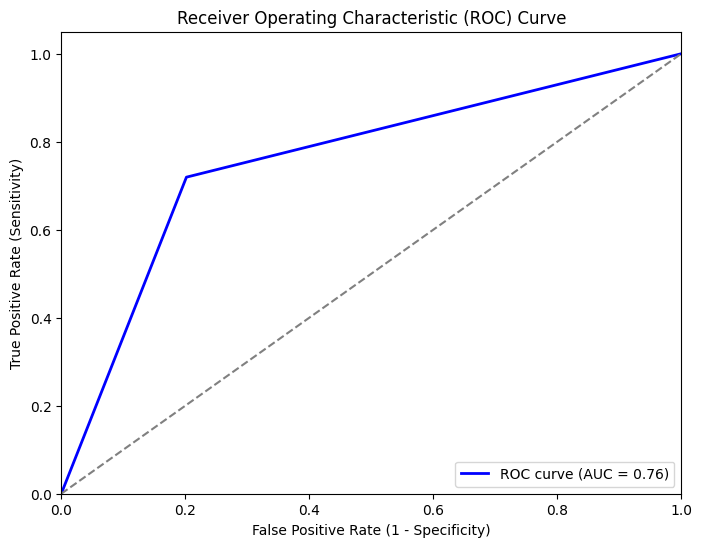

In [79]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix

y_pred_lr = lr_model_tuned.predict(X_scaled)

# Compute ROC curve and AUC
fpr, tpr, thresholds_roc = roc_curve(y, y_pred_lr)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [48]:
confusion_matrix(y_test, y_pred)

array([[66, 14],
       [16, 39]])

In [80]:
confusion_matrix(y, y_pred_lr)

array([[427, 108],
       [101, 259]])

As our data seems to be imbalanced it was already predicted to get relatively poor performance. Let's sample data and try to solve our class imbalance problem.
It is important to note that accuracy is not appropriate when the data is imbalanced. Because the model can achieve higher accuracy by just predicting accurately the majority class while performing poorly on the minority class which in most valuable for us.

### Oversampling

In [49]:
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, SMOTE
from imblearn.combine import SMOTEENN

# oversampling techniques
oversamplers = {
    "ADASYN": ADASYN(random_state=0),
    "Borderline-SMOTE": BorderlineSMOTE(random_state=0),
    "SMOTE": SMOTE(random_state=0),
    "SMOTE-ENN": SMOTEENN(random_state=0)
}

for name, oversampler in oversamplers.items():
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
    
    # model training using resampled data
    model = logistic_regression_model  # Replace YourModel with your actual model
    model.fit(X_train_resampled, y_train_resampled)
    
    # model evaluation on the test set
    accuracy = model.score(X_test, y_test)
    print(f"{name}: Accuracy = {accuracy}")

ADASYN: Accuracy = 0.762962962962963
Borderline-SMOTE: Accuracy = 0.7555555555555555
SMOTE: Accuracy = 0.7703703703703704
SMOTE-ENN: Accuracy = 0.7037037037037037


Oversampling doesn't seem to be working in our favour because our goal is to predict 80% of high traffic correctly and here the accuracy of our model is decreasing.

In [50]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)

In [51]:
scores = []
y_train_list = np.array(y_train)

for train_idx, val_idx in rskf.split(X_train, y_train):
    Xcross_train, ycross_train = X_train[train_idx], y_train_list[train_idx]
    X_val, y_val = X_train[val_idx], y_train_list[val_idx]
    
    logistic_regression_model.fit(Xcross_train, ycross_train)
    ycross_pred = lr_model_tuned.predict(X_val)
    
    scores.append(accuracy_score(ycross_pred, y_val))

print("Scores:", scores)
print("Mean =", np.mean(scores))

Scores: [0.7763157894736842, 0.8026315789473685, 0.756578947368421, 0.756578947368421, 0.7302631578947368, 0.7171052631578947, 0.7368421052631579, 0.7763157894736842, 0.8157894736842105, 0.7763157894736842, 0.756578947368421, 0.7828947368421053, 0.75, 0.7828947368421053, 0.75]
Mean = 0.7644736842105263


### Deep learning to achieve the goal

In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

tf.random.set_seed(0)

# model architecture
tf_model = Sequential([
    Dense(64, activation='relu', input_shape=(7,)),
    Dense(80, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiling the model
tf_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Training the model
tf_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = tf_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/10
24/24 [==============================] - 0s 7ms/step - loss: 0.6640 - accuracy: 0.5789 - val_loss: 0.5841 - val_accuracy: 0.7185
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.5554 - accuracy: 0.7474 - val_loss: 0.5129 - val_accuracy: 0.7852
Epoch 3/10
24/24 [==============================] - 0s 4ms/step - loss: 0.5090 - accuracy: 0.7447 - val_loss: 0.4821 - val_accuracy: 0.8000
Epoch 4/10
24/24 [==============================] - 0s 2ms/step - loss: 0.4913 - accuracy: 0.7434 - val_loss: 0.4776 - val_accuracy: 0.8000
Epoch 5/10
24/24 [==============================] - 0s 4ms/step - loss: 0.4870 - accuracy: 0.7421 - val_loss: 0.4772 - val_accuracy: 0.8000
Epoch 6/10
24/24 [==============================] - 0s 4ms/step - loss: 0.4828 - accuracy: 0.7526 - val_loss: 0.4774 - val_accuracy: 0.7926
Epoch 7/10
24/24 [==============================] - 0s 4ms/step - loss: 0.4784 - accuracy: 0.7592 - val_loss: 0.4760 - val_accuracy: 0.8074
Epoch 8/10
24/24 [==

In [81]:
y_pred_rnn = tf_model.predict(X_scaled)

28/28 [==============================] - 0s 675us/step


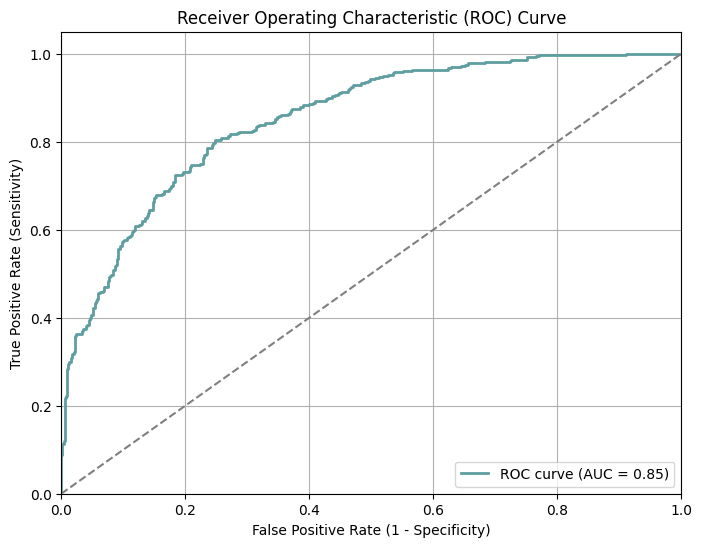

In [82]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix

# Compute ROC curve and AUC
fpr, tpr, thresholds_roc = roc_curve(y, y_pred_rnn)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='cadetblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

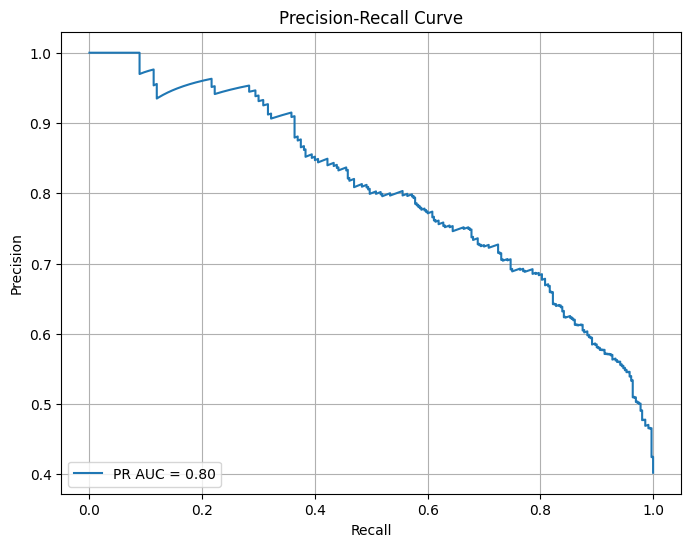

In [83]:
precision, recall, thresholds = precision_recall_curve(y, y_pred_rnn)

# Compute Area Under the Curve (AUC)
auc_score = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {auc_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [84]:
# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
threshold = 0.78
binary_predictions = [1 if prediction > threshold else 0 for prediction in y_pred_rnn.flatten()]

# Print the binary predictions
count_unknown(binary_predictions)

Number of unknown (1) 96
y dimension= 895
Ratio: 0.10726256983240223


In [85]:
site_traffic_df_encoded['DL_predictions'] = binary_predictions
site_traffic_df_encoded

,recipe,calories,carbohydrate,sugar,protein,servings,category_encoded,traffic_encoded,DL_results,DL_predictions
1,2,35.48,38.56,0.66,0.92,4,8,0,0,0
2,3,914.28,42.68,3.09,2.88,1,1,1,0,0
3,4,97.03,30.56,38.63,0.02,4,0,0,0,0
4,5,27.05,1.85,0.80,0.53,4,0,1,1,1
5,6,691.15,3.46,1.65,53.93,2,6,0,0,0
...,...,...,...,...,...,...,...,...,...,...
941,942,186.21,83.94,1.98,22.40,4,2,0,0,0
942,943,1161.00,5.31,22.39,44.22,2,4,1,0,0
944,945,951.74,29.42,3.57,13.87,2,7,0,0,0
945,946,266.61,35.77,0.97,8.07,6,8,0,0,0


In [86]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam  # Optimizer
from tensorflow.keras.losses import BinaryCrossentropy  # Loss function

tf.random.set_seed(0)

# Data preprocessing (replace with your data loading and preparation)
# X_train: Training features (sequences), y_train: Training labels (0 or 1)
# X_test: Testing features (sequences), y_test: Testing labels (0 or 1)

# Define the RNN model
rnn_model = Sequential([
  LSTM(64, return_sequences=True, input_shape=(7,1)),  # Adjust for sequence length
  LSTM(80),  # No return_sequences for final layer
  Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
rnn_model.compile(optimizer=Adam(learning_rate=0.001),  # Adjust learning rate as needed
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

# Train the model
rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model (on unseen test data)
loss, accuracy = rnn_model.evaluate(X_test, y_test)
print('Test Loss:', loss, 'Test Accuracy:', accuracy)


Epoch 1/10
24/24 [==============================] - 3s 39ms/step - loss: 0.6743 - accuracy: 0.6145 - val_loss: 0.6515 - val_accuracy: 0.6645
Epoch 2/10
24/24 [==============================] - 0s 10ms/step - loss: 0.6517 - accuracy: 0.6211 - val_loss: 0.6335 - val_accuracy: 0.6513
Epoch 3/10
24/24 [==============================] - 0s 10ms/step - loss: 0.6287 - accuracy: 0.6474 - val_loss: 0.6044 - val_accuracy: 0.6711
Epoch 4/10
24/24 [==============================] - 0s 10ms/step - loss: 0.5856 - accuracy: 0.6697 - val_loss: 0.5447 - val_accuracy: 0.7368
Epoch 5/10
24/24 [==============================] - 0s 9ms/step - loss: 0.5251 - accuracy: 0.7421 - val_loss: 0.5210 - val_accuracy: 0.7368
Epoch 6/10
24/24 [==============================] - 0s 11ms/step - loss: 0.5066 - accuracy: 0.7500 - val_loss: 0.5101 - val_accuracy: 0.7434
Epoch 7/10
24/24 [==============================] - 0s 9ms/step - loss: 0.5038 - accuracy: 0.7461 - val_loss: 0.5067 - val_accuracy: 0.7500
Epoch 8/10
24/2

Running LSTM using different nurones sizes does not affect the accuracy.

In [71]:
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, valid_scores = learning_curve(estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=10)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
    plt.plot(train_sizes, valid_scores_mean, 'o-', label='Cross-validation score')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title(f'Learning Curve')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

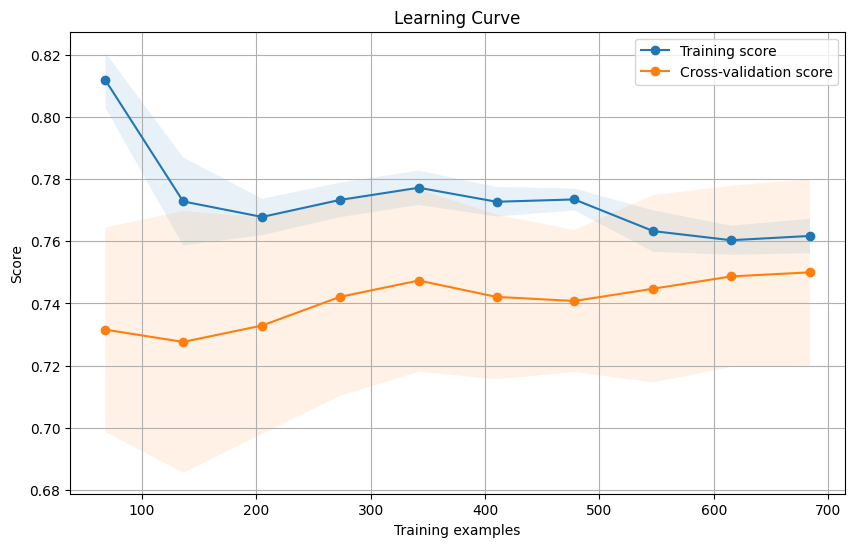

In [72]:
# Learning curve for model logistic regression model
plot_learning_curve(logistic_regression_model, X_train, y_train)

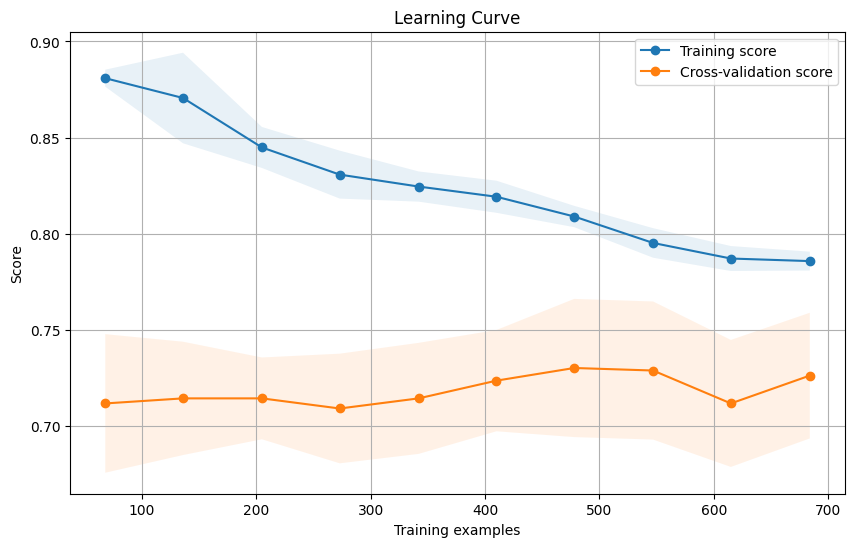

In [74]:
# Learning curve for SVC classifier
plot_learning_curve(svc_model, X_train, y_train)

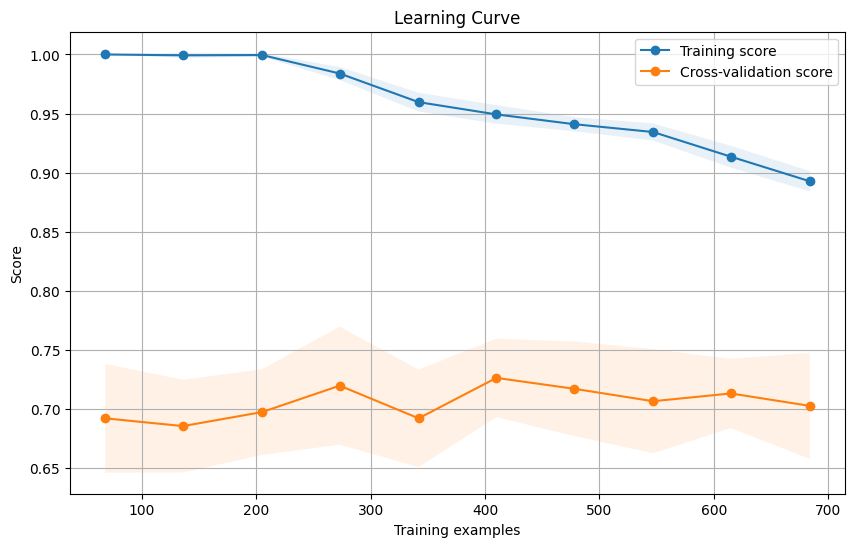

In [75]:
# Learning curve for Gradient Boosting Model
plot_learning_curve(gradient_boosting_model, X_train, y_train)

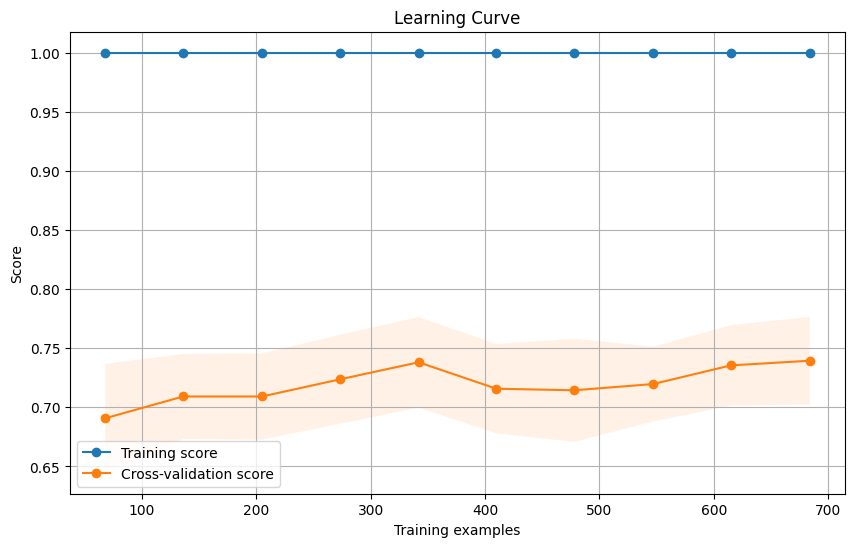

In [76]:
# Learning curve for Random Forest Model
plot_learning_curve(random_forest_model, X_train, y_train)

In [88]:
predictions_df = site_traffic_df_cleaned.copy()
predictions_df['LR_predictions'] = label_encoder.inverse_transform(y_pred_lr)
# predictions_df['SVC_predictions'] = label_encoder.inverse_transform(y_pred4)
predictions_df['RNN_predictions'] = label_encoder.inverse_transform(binary_predictions)
predictions_df

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,LR_predictions,RNN_predictions
1,2,35.48,38.56,0.66,0.92,Potato,4,High,High,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,unknown,unknown,High
3,4,97.03,30.56,38.63,0.02,Beverages,4,High,unknown,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,unknown,unknown,unknown
5,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High,High,High
...,...,...,...,...,...,...,...,...,...,...
941,942,186.21,83.94,1.98,22.40,Chicken,4,High,unknown,High
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,unknown,High,High
944,945,951.74,29.42,3.57,13.87,Pork,2,High,High,High
945,946,266.61,35.77,0.97,8.07,Potato,6,High,High,High


In [89]:
unknown_traffic_df = predictions_df[predictions_df['high_traffic']=='unknown']
unknown_traffic_df

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,LR_predictions,RNN_predictions
2,3,914.28,42.68,3.09,2.88,Breakfast,1,unknown,unknown,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,unknown,unknown,unknown
6,7,183.94,47.95,9.75,46.71,Chicken,4,unknown,unknown,High
7,8,299.14,3.17,0.40,32.40,Lunch/Snacks,4,unknown,High,High
9,10,248.28,48.54,3.99,113.85,Chicken,2,unknown,unknown,High
...,...,...,...,...,...,...,...,...,...,...
932,933,1017.32,85.12,1.71,1.85,Potato,1,unknown,High,High
939,940,2283.29,34.34,5.12,17.57,Chicken,6,unknown,unknown,High
940,941,1337.50,49.91,0.76,57.90,Chicken,4,unknown,unknown,High
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,unknown,High,High


In [91]:
unknown_traffic_df['LR_predictions'].value_counts()

unknown    259
High       101
Name: LR_predictions, dtype: int64

In [93]:
unknown_traffic_df['RNN_predictions'].value_counts()

High       269
unknown     91
Name: RNN_predictions, dtype: int64

In [99]:
print(classification_report(y, y_pred_lr))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80       535
           1       0.71      0.72      0.71       360

    accuracy                           0.77       895
   macro avg       0.76      0.76      0.76       895
weighted avg       0.77      0.77      0.77       895



In [100]:
print(classification_report(y, binary_predictions))

              precision    recall  f1-score   support

           0       0.66      0.99      0.79       535
           1       0.95      0.25      0.40       360

    accuracy                           0.69       895
   macro avg       0.81      0.62      0.60       895
weighted avg       0.78      0.69      0.64       895



### 3.2. Model Fine Tuning

#### 3.2.1. Using Ensemble Methods for fine tunning

1. Bagging (Bootstrap Aggregating):

In [104]:
from sklearn.ensemble import BaggingClassifier

# Bagging with logistic_regression_model
bagging_lr = BaggingClassifier(base_estimator=logistic_regression_model, n_estimators=10, random_state=0)
bagging_lr.fit(X_train, y_train)
y_bagging_lr = bagging_lr.predict(X_test)

# Bagging with SVC classifier
bagging_svc = BaggingClassifier(base_estimator=svc_model, n_estimators=10, random_state=0)
bagging_svc.fit(X_train, y_train)
y_bagging_svc = bagging_svc.predict(X_test)


In [105]:
accuracy_score(y_bagging_lr, y_test)

0.7703703703703704

In [106]:
accuracy_score(y_bagging_svc, y_test)

0.7777777777777778

At least the accuracy of SVC classier is improved.

2. Boosting

In [109]:
from sklearn.ensemble import AdaBoostClassifier

# Boosting with logistic_regression_model
adaboost_lr = AdaBoostClassifier(base_estimator=logistic_regression_model, n_estimators=50, random_state=0)
adaboost_lr.fit(X_train, y_train)
y_adaboost_lr = adaboost_lr.predict(X_test)

# Boosting with SVC classier
# adaboost_svc = AdaBoostClassifier(base_estimator=svc_model, n_estimators=50, random_state=0)
# adaboost_svc.fit(X_train, y_train)
# y_adaboost_svc = adaboost_svc.predict(X_test)

In [110]:
accuracy_score(y_adaboost_lr, y_test)

0.7703703703703704

3. Stacking

In [126]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define meta-estimator (logistic regression)
meta_estimator = LogisticRegression(random_state=0)

# Stacking with logistic_regression_model_req and logistic_regression_model_best
estimators = [('LR', logistic_regression_model), ('SVC', svc_model)]
stacking = StackingClassifier(estimators=estimators, final_estimator=meta_estimator)

# Fit stacking classifier with corresponding subsets of training data
stacking.fit(X_train, y_train)  # Use X_train_req and y_train_req for logistic_regression_model_req
y_stacking = stacking.predict(X_test)
stacking_accuracy = accuracy_score(y_stacking, y_test)
stacking_accuracy

0.7851851851851852

In [128]:
# logistic regression model fitting
logit_model = sm.Logit(y_train, sm.add_constant(X_train))
logit_result = logit_model.fit()

# summary of logistic regression results
print(logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.490626
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:        traffic_encoded   No. Observations:                  760
Model:                          Logit   Df Residuals:                      752
Method:                           MLE   Df Model:                            7
Date:                Thu, 14 Mar 2024   Pseudo R-squ.:                  0.2716
Time:                        21:44:51   Log-Likelihood:                -372.88
converged:                       True   LL-Null:                       -511.89
Covariance Type:            nonrobust   LLR p-value:                 2.953e-56
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6686      0.099     -6.730      0.000      -0.863      -0.474
x1             0.0433      0.